# Make visualizations for poster

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch, Circle
import os
import json
from dual_alm_rnn_models import TwoHemiRNNTanh_single_readout
from dual_alm_rnn_exp import DualALMRNNExp
import sys
import argparse, os, math, pickle, json

plt.rcParams['pdf.fonttype'] = '42' 

In [20]:
traces = np.load('dual_alm_rnn_data/train/onehot_sensory_inputs_simple.npy')
labels = np.load('dual_alm_rnn_data/train/onehot_trial_type_labels_simple.npy')
exp=DualALMRNNExp()

In [ ]:
traces.shape, labels.shape, labels[:3]

((1000, 125, 2), (1000,), array([1, 1, 0]))

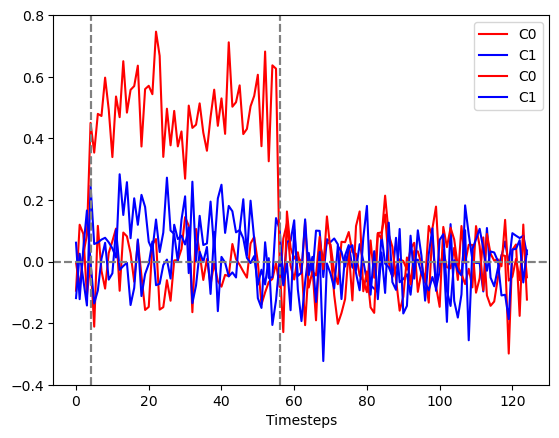

In [42]:
plt.plot(traces[1, :, 0]*0.2+np.random.randn(125) * 0.1, c='red', label='C0')
plt.plot(traces[1, :, 1]*0.2+np.random.randn(125) * 0.1, c='blue', label='C1')
plt.axhline(0, ls='--', color='grey')
plt.axvline(exp.sample_begin, ls='--', color='grey')
plt.axvline(exp.delay_begin, ls='--', color='grey')
plt.xlabel('Timesteps')
plt.ylim(-0.4,0.8)
plt.legend()
plt.savefig('figs/right_sens_1.pdf')


plt.plot(traces[2, :, 0]+np.random.randn(125) * 0.1, c='red', label='C0')
plt.plot(traces[2, :, 1]+np.random.randn(125) * 0.1, c='blue', label='C1')
plt.axhline(0, ls='--', color='grey')
plt.axvline(exp.sample_begin, ls='--', color='grey')
plt.axvline(exp.delay_begin, ls='--', color='grey')
plt.xlabel('Timesteps')
plt.ylim(-0.4,0.8)
plt.legend()
plt.savefig('figs/lef_sens_5.pdf')




Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_single_readout_fixed_input/n_neurons_4_random_seed_0/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_10.pth


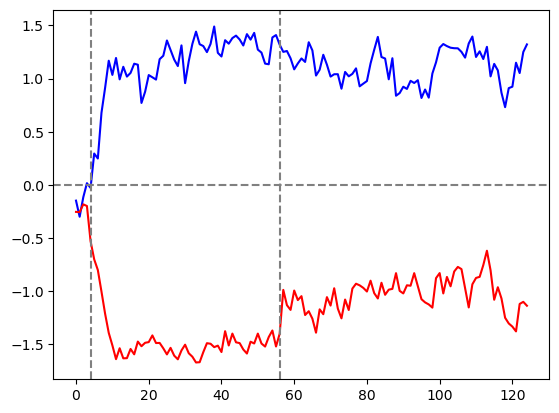

In [38]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_10.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()


train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs_simple.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels_simple.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input.shape

l_trial_input_all = l_trial_input
r_trial_input_all = r_trial_input

for i in range(1):
    l_trial_input = l_trial_input_all[i].reshape(1, exp.T, 2)
    r_trial_input = r_trial_input_all[i].reshape(1, exp.T, 2)
    hs, zs = model(l_trial_input)
    hs_r, zs_r = model(r_trial_input)

 # Add zs as a fifth subplot, centered in the third row, same aspect ratio as others
    plt.plot(zs_r[0, :, 0].detach().cpu().numpy(), color='blue', alpha=1.0)
    plt.plot(zs[0, :, 0].detach().cpu().numpy(), color='red', alpha=1.0)
    plt.axhline(0, ls='--', color='grey')
    plt.axvline(exp.sample_begin, ls='--', color='grey')
    plt.axvline(exp.delay_begin, ls='--', color='grey')
    plt.savefig('figs/readout_traj.pdf')




[0.89371824, 0.7517734, 0.61844724, 0.5482109, 0.5359054, 0.518846, 0.5229925, 0.37961188, 0.37457153, 0.27524334, 0.23808889, 0.20363088, 0.1743532]


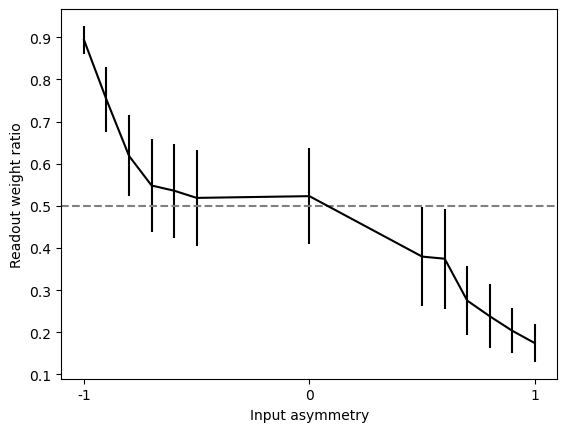

In [44]:

input_asym = [(1,0), (1,0.1), (1,0.2), (1,0.3), (1,0.4), (1,0.5), (1,1), (0.5,1), (0.4,1), (0.3,1), (0.2,1), (0.1,1), (0,1)] # Sane as BK

# Initialize experiment
exp = DualALMRNNExp()
weights_dict = np.load('small_rnn_corrupted_weights_0p5noise_epoch11_40epochs.npy', allow_pickle=True)
weights_dict = np.load('small_rnn_sherlock_weights_corruption_0p7noise_epoch11.npy', allow_pickle=True)
weights_dict = np.load('small_rnn_sherlock_weights_fixed_input.npy', allow_pickle=True)
# weights_dict = np.load('small_rnn_corrupted_weights_fixed_input_0p5noise_epoch15_40epochs.npy', allow_pickle=True)

all_weights = []
control_std = []
for asym in input_asym:


    # all_weights += [np.mean([np.sum(np.abs(weights_dict.item()[asym][i][0, :exp.n_neurons//2])) / np.sum(np.abs(weights_dict.item()[asym][i][0, exp.n_neurons//2:])) for i in range(10)])]
    # control_std += [np.std([np.sum(np.abs(weights_dict.item()[asym][i][0, :exp.n_neurons//2])) / np.sum(np.abs(weights_dict.item()[asym][i][0, exp.n_neurons//2:])) for i in range(10)]) / np.sqrt(10)]


    all_weights += [np.mean([np.sum(np.abs(weights_dict.item()[asym][i][0, :exp.n_neurons//2])) / np.sum(np.abs(weights_dict.item()[asym][i][0, :])) for i in range(10)])]
    control_std += [np.std([np.sum(np.abs(weights_dict.item()[asym][i][0, :exp.n_neurons//2])) / np.sum(np.abs(weights_dict.item()[asym][i][0, :])) for i in range(10)]) / np.sqrt(10)]

    # all_weights = [weights_dict.item()[asym][i][0, :exp.n_neurons//2] / weights_dict.item()[asym][i][0, :] for i in range(10)]
    # for seed in range(1,10):
    #     exp = DualALMRNNExp()
    #     exp.configs['xs_left_alm_amp'] = asym[0]
    #     exp.configs['xs_right_alm_amp'] = asym[1]

    #     # For each asymmetry, print the logs path for the config
    #     exp.init_sub_path('train_type_modular')
    #     logs_path = os.path.join(exp.configs['logs_dir'], exp.configs['model_type'], exp.sub_path)
    #     # print(f"Input asymmetry {asym}: logs path = {logs_path}")

    #     weights = np.load(os.path.join(logs_path, 'readout_weights_epoch_final.npy'))
    #     ratio = np.sum(np.abs(weights)[0, :exp.n_neurons//2]) / np.sum(np.abs(weights)[0, :])
    #     # all_weights.append(weights)
    
    # weights_dict[asym] = all_weights
# import pdb; pdb.set_trace()
print(all_weights)
# xlabels=[-1, -0.8, -0.6, -0.2, 0, 0.2, 0.6, 0.8, 1]
xlabels=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, 0, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# plt.plot(xlabels, all_weights, ls='--', marker='o')
plt.errorbar(xlabels, all_weights, yerr=control_std, label='Control', color='black', ls='-')
# plt.errorbar(xlabels, right_pert_acc, yerr=right_pert_std, label='Right pert', color='darkgrey')
# plt.errorbar(xlabels, left_pert_acc, yerr=left_pert_std, label='Left pert', color='lightgrey')
plt.ylabel('Readout weight ratio')
plt.xlabel('Input asymmetry')
# plt.ylim(0, 1)
plt.xticks([-1,0,1],[-1,0,1])
# plt.legend()
plt.axhline(0.5, ls='--', color='grey')
plt.savefig('figs/all_competition_fixed_input.pdf')
# plt.savefig('figs/all_competition_tenseeds_corruption_0p7noise_epoch11.pdf')
plt.show()
# breakpoint()


In [ ]:
exp = DualALMRNNExp()

if 'train_type_modular_corruption' in exp.configs['train_type']:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/train_type_modular_corruption/onehot_cor_type_{}_epoch_{}_noise_{:.2f}/n_neurons_4_random_seed_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['corruption_type'],
            exp.configs['corruption_start_epoch'],
            float(exp.configs['corruption_noise']),
            exp.configs['random_seed'],
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
elif 'asymmetric_fix' in exp.configs['train_type']:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            exp.configs['random_seed'],
            exp.configs['unfix_epoch'],
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])),
            allow_pickle=True
    )
else:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            exp.configs['random_seed'],
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
epochs = np.arange(1, len(results_dict) + 1)
readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
agreement_frac = n_trials_agreed / n_trials

# Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

corruption_start_epoch = exp.configs['corruption_start_epoch']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top subplot: Readout accuracies
ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax1.set_ylabel('Readout Accuracy (Control)')
ax1.set_title('Readout Accuracy Over Training (Control Trials)')
ax1.set_xticks(epochs)
ax1.set_ylim(0.4, 1.05)
ax1.legend()

# Bottom subplot: Agreement
ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Fraction of Trials with L=R')
ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
ax2.set_xticks(epochs)
ax2.set_ylim(0.4, 1.05)
ax2.legend()

plt.tight_layout()
if exp.configs['train_type'] == 'train_type_modular_corruption':
    plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
                                                                                                            exp.configs['xs_left_alm_amp'], 
                                                                                                            exp.configs['xs_right_alm_amp'], 
                                                                                                            exp.configs['corruption_start_epoch'], 
                                                                                                            exp.configs['corruption_noise'], 
                                                                                                            exp.configs['corruption_type']))
elif 'asymmetric_fix' in exp.configs['train_type']:
    plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
                                                                                            exp.configs['xs_left_alm_amp'], 
                                                                                            exp.configs['xs_right_alm_amp'], 
                                                                                            exp.configs['unfix_epoch'],
                                                                                            exp.configs['train_type']))
else:
    plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
                                                                                            exp.configs['xs_left_alm_amp'], 
                                                                                            exp.configs['xs_right_alm_amp'], 
                                                                                            exp.configs['train_type']))
plt.show()